In [3]:
# =========================
# Cell 1 — Imports & Debug
# =========================

import os
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, medfilt

# -------------------------
# Reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)

In [6]:
# ======================================
# Cell 2 — Image Loading & Deskewing
# ======================================

def load_image(path: str) -> np.ndarray:
    """
    Safely load an ECG image.
    Ensures BGR format for OpenCV compatibility.
    """
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")

    # Convert grayscale → BGR for uniform downstream handling
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    return img

def deskew_image(img_bgr: np.ndarray) -> np.ndarray:
    """
    Estimate and correct image skew using dominant horizontal grid lines.
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Canny edges for line detection
    edges = cv2.Canny(blur, 50, 150, apertureSize=3)

    # Hough line detection: threshold is 'votes' needed to identify a line.
    # 150 is a reasonable starting point for large images.
    lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=150)

    collected_thetas = []
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            # LOGIC FIX: Keep lines that are near-horizontal.
            # In Hough space, horizontal lines have theta near pi/2 (90 degrees).
            if abs(theta - np.pi/2) < np.deg2rad(10):
                collected_thetas.append(theta)

    if not collected_thetas:
        print("[deskew] No horizontal lines detected, skipping.")
        return img_bgr.copy()

    # Median theta is more robust against outlier diagonal noise
    median_theta = np.median(collected_thetas)
    
    # Calculate skew angle in degrees.
    # If theta is 95 deg, the deviation from 90 deg is 5 deg.
    skew_angle_deg = np.rad2deg(median_theta - np.pi/2)

    # ANGLE FIX: To 'undo' a skew, we rotate by the skew itself in getRotationMatrix2D
    # because getRotationMatrix2D uses counter-clockwise positive rotation.
    if abs(skew_angle_deg) < 0.1:
        return img_bgr.copy()

    h, w = img_bgr.shape[:2]
    center = (w // 2, h // 2)
    
    # Generate the 2x3 rotation matrix
    M = cv2.getRotationMatrix2D(center, angle=skew_angle_deg, scale=1.0)

    # BORDER FIX: For ECGs/documents, BORDER_REPLICATE can cause streaking. 
    # BORDER_CONSTANT with a white background is cleaner for grids.
    rotated = cv2.warpAffine(
        img_bgr,
        M,
        (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT, # replicate the border, to prevent the 
        # 'streaks' at borders of image
        borderValue=(255, 255, 255)  # Fills empty space with white
    )

    return rotated

[load_image] Loaded image shape: (1700, 2200, 4)
[load_image] Loaded image shape: (1700, 2200, 4)


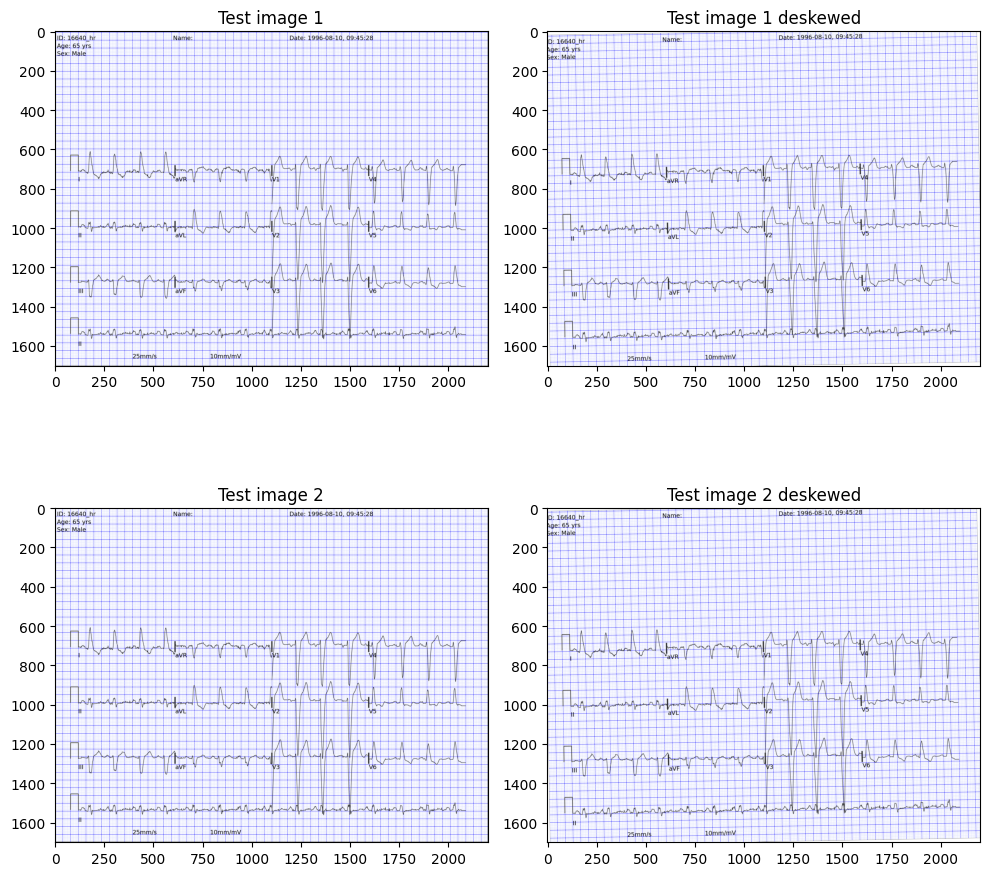

In [3]:
# =======================================================
# Cell 2.1 - Sanity check of loading & deskewing function
# =======================================================

output_dir = '../working'

test_imgs = '../physionet_ecg_competition_2025/test'
test_img_1 = f"{test_imgs}/2352854581.png"
test_img_2 = f"{test_imgs}/2352854581.png"

img1 = load_image(test_img_1)
img2 = load_image(test_img_2)
deskewed_1 = deskew_image(img1)
deskewed_2 = deskew_image(img2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))

ax1.imshow(img1)
ax1.set_title('Test image 1')

ax2.imshow(deskewed_1)
ax2.set_title('Test image 1 deskewed')

ax3.imshow(img2)
ax3.set_title('Test image 2')

ax4.imshow(deskewed_2)
ax4.set_title('Test image 2 deskewed')

plt.savefig(f'{output_dir}/my_four_images.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [4]:
# =================================================================
# Cell 2 correction: `deskew_image` is gonna return just the `img`.
# We'll keep it for pipeline consistency, so that for future
# ecg images which requires deskewing, we'd be able to include 
# deskewing capacility
# =================================================================

def deskew_image(img: np.ndarray) -> np.ndarray:
    """
    PhysioNet ECG images are already aligned.
    Deskewing causes geometric distortion and must be skipped.
    """
    print("[deskew] skipped (images are already aligned)")
    return img

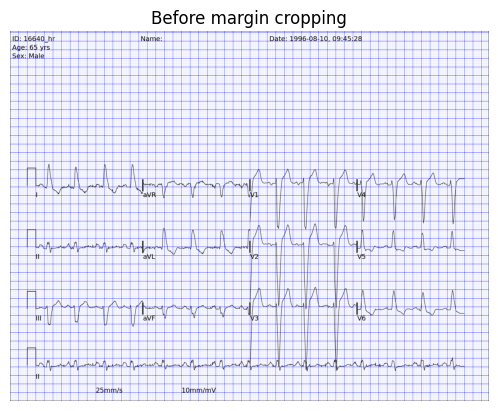

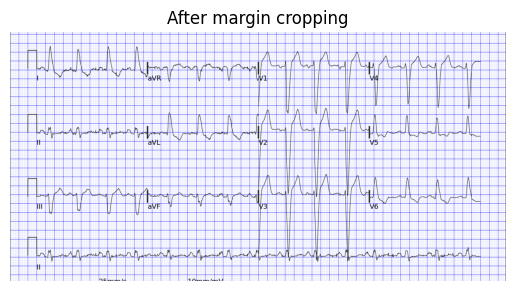

In [5]:
# =====================================
# Cell 3 - Splitting the 12 leads
# =====================================

# ============================================================
# Cell 3.0.0 - Top to bottom cropping technique's sanity check
# ============================================================

h, w = img1.shape[:2]

top_crop = int(0.32 * h)    # removes patient metadata
bottom_crop = int(0.03 * h) # removes scale text

cropped_image = img1[top_crop : h - bottom_crop, :]

plt.imshow(img1)
plt.title("Before margin cropping")
plt.axis("off")
plt.show()

plt.imshow(cropped_image)
plt.title("After margin cropping")
plt.axis("off")
plt.show()

Cropped test for horizontal 1st shaped:  (375, 2200, 4)
For 2nd crop starting point:  375
Cropped test for horizontal 2nd shaped:  (413, 2200, 4)
For 3rd crop starting point:  613
Cropped test for horizontal 3rd shaped:  (338, 2200, 4)
For 4th crop starting point:  876
Cropped test for horizontal 4th shaped:  (195, 2200, 4)


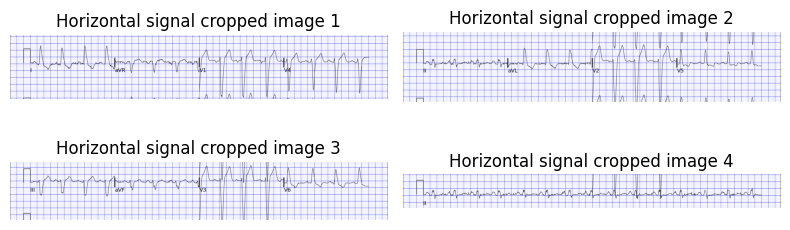

In [6]:
# ================================================================================
# Cell 3.0.1 - Sanity check of horizontal bands cropping techniques to be deployed
# ================================================================================

# cropped_image.shape: (1105, 2200, 4)
cropped_copy = cropped_image.copy()
horizontal_sign_imgs = []
start_crop = 0
height1 = int(cropped_copy.shape[0])

test_sign_crop1 = cropped_copy[start_crop : int(height1*0.34), :] # shape: (375, 2200, 4)
print("Cropped test for horizontal 1st shaped: ", test_sign_crop1.shape)
horizontal_sign_imgs.append(test_sign_crop1)

start_crop = int(test_sign_crop1.shape[0])
print("For 2nd crop starting point: ", start_crop)
height2 = int(height1 - int(test_sign_crop1.shape[0])) - 55
test_sign_crop2 = cropped_copy[int(start_crop - (start_crop * 0.3)) : height2]
print("Cropped test for horizontal 2nd shaped: ", test_sign_crop2.shape) # shape: (413, 2200, 4)
horizontal_sign_imgs.append(test_sign_crop2)

start_crop = int(test_sign_crop2.shape[0]) + 200
print("For 3rd crop starting point: ", start_crop)
height3 = int(height1 - int(height1 * 0.14))
test_sign_crop3 = cropped_copy[start_crop : height3, :]
print("Cropped test for horizontal 3rd shaped: ", test_sign_crop3.shape) # shape: (338, 2200, 4)
horizontal_sign_imgs.append(test_sign_crop3)

start_crop = (int(test_sign_crop3.shape[0])*2) + 200
print("For 4th crop starting point: ", start_crop)
height4 = int(height1 - height1 * 0.03)
test_sign_crop4 = cropped_copy[start_crop : height4, :]
print("Cropped test for horizontal 4th shaped: ", test_sign_crop4.shape) # shape: (195, 2200, 4)
horizontal_sign_imgs.append(test_sign_crop4)

fig, axs = plt.subplots(2, 2, figsize=(8, 3))

for i, ax in enumerate(axs.flat):
    img = horizontal_sign_imgs[i]
    ax.set_title(f"Horizontal signal cropped image {i+1}")
    ax.imshow(img)
    ax.axis('off')

plt.savefig(f'{output_dir}/horizontal_signal_crops.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [7]:
# ====================================================================================
# Cell 3.0.2 - Splitting 12 leads based on the vertical separators of horizontal bands
# ====================================================================================

def get_precise_boundaries(band_img, num_leads=4, debug=False):
    """
    Computes precise vertical lead boundaries using ECG grid geometry.
    Anchors boundaries to bold (5 mm) grid lines.
    """

    # 1. Convert to grayscale
    gray = cv2.cvtColor(band_img, cv2.COLOR_BGR2GRAY)

    # 2. Emphasize vertical grid lines
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.abs(sobelx)
    sobelx /= (sobelx.max() + 1e-6)

    # 3. Column-wise vertical energy
    col_energy = sobelx.mean(axis=0)

    # 4. Smooth profile
    col_energy = cv2.GaussianBlur(
        col_energy.reshape(1, -1),
        (1, 31),
        0
    ).ravel()

    # 5. Detect bold vertical grid lines
    peaks, _ = find_peaks(
        col_energy,
        distance=30,
        prominence=np.percentile(col_energy, 80)
    )

    if len(peaks) < 10:
        raise RuntimeError("Insufficient grid lines detected")

    # 6. Grid spacing between bold lines (≈5 mm)
    diffs = np.diff(peaks)
    bold_grid_spacing_px = np.median(diffs)

    # 7. Convert to pixels per mm
    pixels_per_mm = bold_grid_spacing_px / 5.0

    # 8. Lead width (ECG standard)
    lead_width_px = int(62.5 * pixels_per_mm)

    # 9. Anchor to first valid grid line
    first_x = peaks[0]

    boundaries = []
    for i in range(num_leads):
        x_start = int(first_x + i * lead_width_px)
        x_end   = int(x_start + lead_width_px)
        boundaries.append((x_start, x_end))

    # 10. Debug visualization
    if debug:
        dbg = band_img.copy()
        for i, (x0, x1) in enumerate(boundaries):
            cv2.line(dbg, (x0, 0), (x0, dbg.shape[0]), (0, 255, 0), 2)
            cv2.line(dbg, (x1, 0), (x1, dbg.shape[0]), (0, 0, 255), 2)
            cv2.putText(
                dbg, f"L{i+1}", (x0 + 5, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2
            )

        plt.figure(figsize=(14, 3))
        plt.imshow(dbg)
        plt.title("Grid-anchored lead boundaries")
        plt.axis("off")
        plt.show()

    return boundaries



def split_ecg_panels_refined(img_bgr, debug=False):
    h, w = img_bgr.shape[:2]

    # 1. Crop margins (Your empirical values)
    top_crop = int(0.32 * h)
    bottom_crop = int(0.03 * h)
    core = img_bgr[top_crop : h - bottom_crop, :]
    core_h, core_w = core.shape[:2]

    # 2. Split into 4 horizontal bands

    h1 = int(core_h)
    band1 = core[0 : int(h1 * 0.34), :]

    start_crop = int(band1.shape[0])
    h2 = int(core_h - start_crop) - 55
    band2 = core[int(start_crop - (start_crop * 0.3)) : h2, :]

    start_crop = int(band2.shape[0]) + 200
    h3 = int(h1 - int(h1 * 0.14))
    band3 = core[start_crop : h3, :] # Approximation based on height3

    start_crop = (int(band3.shape[0]) * 2) + 200
    h4 = int(h1 - int(h1 * 0.03))
    band4 = core[start_crop : h4, :]

    bands = [band1, band2, band3, band4]

    # 3. Detect precise vertical boundaries using the first band
    # This identifies the 4 columns by finding the 3 separators
    lead_boundaries = get_precise_boundaries(band1, debug=debug)
    lead_layout = [
        ["I",   "aVR", "V1", "V4"],
        ["II",  "aVL", "V2", "V5"],
        ["III", "aVF", "V3", "V6"]
    ]

    panels = {}

    # 4. Extract 12 leads using dynamic boundaries
    for r in range(3):
        for c in range(4):
            x_start, x_end = lead_boundaries[c]
            # Sanity check — do NOT silently clip
            if x_start < 0 or x_end > core_w:
                raise ValueError(
                    f"Lead boundary out of bounds: ({x_start}, {x_end}) "
                    f"for image width {core_w}"
                )

            panels[lead_layout[r][c]] = bands[r][:, x_start:x_end]

    # 5. Rhythm strip (Full Lead II)
    panels["II_full"] = bands[3]

    if debug:
        dbg = band1.copy()
        for i, (x0, x1) in enumerate(lead_boundaries):
            cv2.line(dbg, (x0, 0), (x0, dbg.shape[0]), (0, 255, 0), 2)
            cv2.line(dbg, (x1, 0), (x1, dbg.shape[0]), (0, 0, 255), 2)
            cv2.putText(
                dbg, f"L{i+1}", (x0 + 5, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2
            )

        plt.figure(figsize=(14, 3))
        plt.imshow(dbg)
        plt.title("Vertical lead boundaries (grid-anchored)")
        plt.axis("off")
        plt.show()

    return panels

# Usage
# panels = split_ecg_panels_refined(your_img, debug=True)

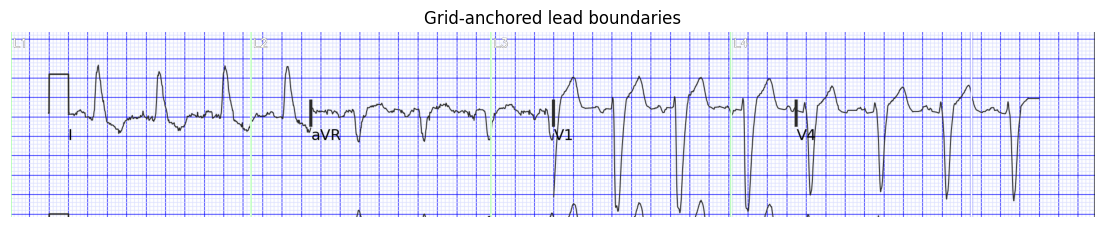

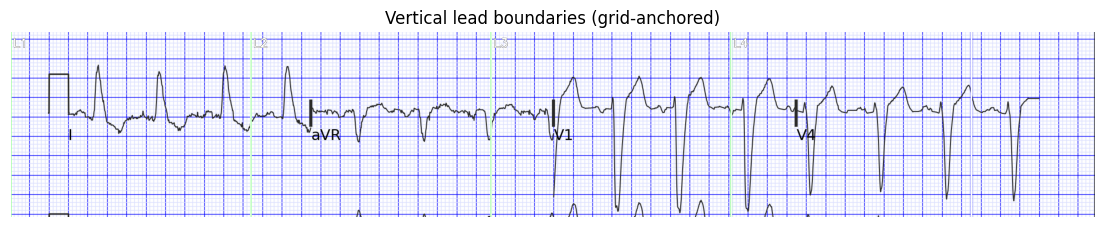

{'I': array([[[184, 185, 226, 255],
         [247, 248, 254, 255],
         [247, 248, 254, 255],
         ...,
         [247, 248, 254, 255],
         [247, 248, 254, 255],
         [241, 243, 254, 255]],
 
        [[182, 182, 227, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [247, 248, 254, 255]],
 
        [[182, 182, 227, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [247, 248, 254, 255]],
 
        ...,
 
        [[182, 182, 227, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         [247, 248, 254, 255]],
 
        [[182, 182, 227, 255],
         [255, 255, 255, 255],
         [255, 255, 255, 255],
         ...,
         [255, 255, 255, 255],
         [255, 255, 255, 255],

In [8]:
split_ecg_panels_refined(img1, debug=True)

In [12]:
# ===============================================================
# Cell 4 - Mask acquiring by removing grid from splitted ECG Lead
# ===============================================================

def remove_ecg_grid(gray_img, debug=False):
    """
    Removes ECG background grid using morphology only.
    Preserves ECG waveform while eliminating horizontal and vertical grid lines.
    """

    # ------------------------------------------------
    # 1. Normalize & binarize (signal becomes white)
    # ------------------------------------------------
    gray = gray_img.copy()

    # Light smoothing to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Adaptive threshold works better than fixed for scanned ECGs
    binary = cv2.adaptiveThreshold(
        gray,
        255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=21,
        C=10
    )

    # ------------------------------------------------
    # 2. Detect vertical grid lines (long & straight)
    # ------------------------------------------------
    vertical_kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, (1, 35)
    )
    vertical_grid = cv2.morphologyEx(
        binary,
        cv2.MORPH_OPEN,
        vertical_kernel,
        iterations=1
    )

    # ------------------------------------------------
    # 3. Detect horizontal grid lines
    # ------------------------------------------------
    horizontal_kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, (35, 1)
    )
    horizontal_grid = cv2.morphologyEx(
        binary,
        cv2.MORPH_OPEN,
        horizontal_kernel,
        iterations=1
    )

    # ------------------------------------------------
    # 4. Combine grid components
    # ------------------------------------------------
    grid_mask = cv2.bitwise_or(vertical_grid, horizontal_grid)

    # ------------------------------------------------
    # 5. Remove grid from binary signal
    # ------------------------------------------------
    signal_only = cv2.subtract(binary, grid_mask)

    # ------------------------------------------------
    # 6. Restore ECG continuity
    # ------------------------------------------------
    signal_kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (3, 3)
    )

    signal_only = cv2.morphologyEx(
        signal_only,
        cv2.MORPH_CLOSE,
        signal_kernel,
        iterations=1
    )

    signal_only = cv2.morphologyEx(
        signal_only,
        cv2.MORPH_OPEN,
        signal_kernel,
        iterations=1
    )

    # ------------------------------------------------
    # 7. Optional cleanup of tiny dots
    # ------------------------------------------------
    signal_only = cv2.medianBlur(signal_only, 3)

    if debug:
        titles = [
            "Binary (signal + grid)",
            "Vertical grid",
            "Horizontal grid",
            "Grid mask",
            "Final signal mask"
        ]
        imgs = [
            binary,
            vertical_grid,
            horizontal_grid,
            grid_mask,
            signal_only
        ]

        plt.figure(figsize=(18, 4))
        for i, (img, title) in enumerate(zip(imgs, titles)):
            plt.subplot(1, 5, i + 1)
            plt.imshow(img, cmap="gray")
            plt.title(title)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    return signal_only

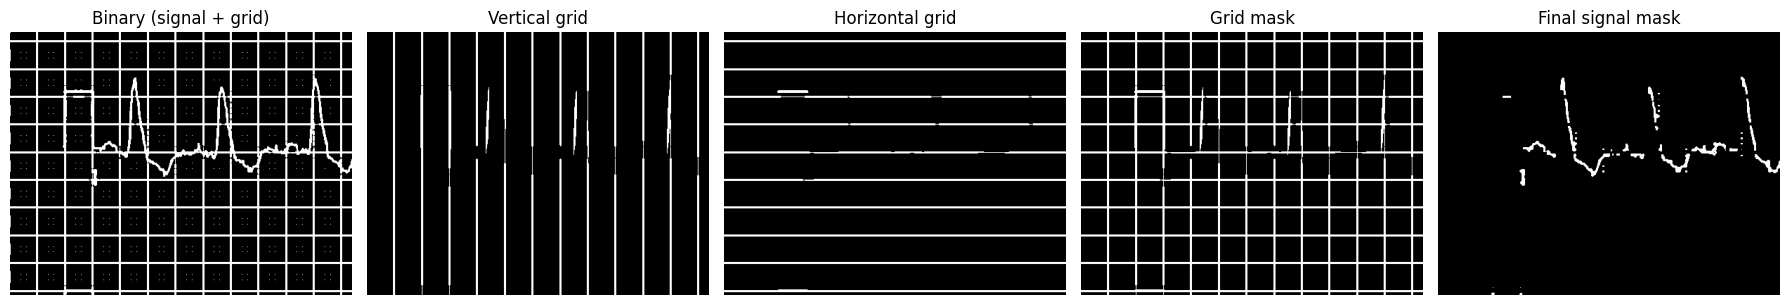

In [13]:
# =============================================================
# Cell 4.1 - Sanity check (grid removal from signal-first mask)
# =============================================================

panels = split_ecg_panels_refined(img1, debug=False)

panel_I = panels["I"]
gray_I = cv2.cvtColor(panel_I, cv2.COLOR_BGR2GRAY)

signal_mask_I = remove_ecg_grid(gray_I, debug=True)

In [14]:
# ============================================================
# Step 5.0 - ECG trace extraction from binary mask
# ============================================================

def extract_ecg_trace(signal_mask, debug=False):
    """
    Extracts a 1D ECG trace from a binary signal mask.
    Uses column-wise median to remain robust to thickness & noise.
    
    Returns:
        x_coords : array of x pixel indices
        y_coords : array of y pixel indices (NaN where missing)
    """

    h, w = signal_mask.shape
    y_trace = np.full(w, np.nan)

    for x in range(w):
        ys = np.where(signal_mask[:, x] > 0)[0]
        if len(ys) > 0:
            y_trace[x] = np.median(ys)

    x_trace = np.arange(w)

    if debug:
        plt.figure(figsize=(12, 3))
        plt.imshow(signal_mask, cmap="gray")
        plt.plot(x_trace, y_trace, color="red", linewidth=1)
        plt.title("Extracted ECG trace (overlay)")
        plt.axis("off")
        plt.show()

    return x_trace, y_trace

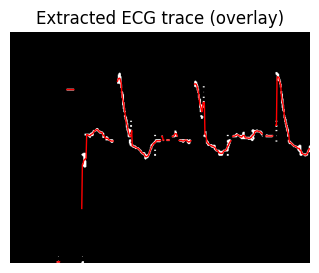

In [15]:
# ============================================
# Step 5.1 - Sanity check of trace extraction
# ============================================

panels = split_ecg_panels_refined(img1, debug=False)

panel_I = panels["I"]
gray_I = cv2.cvtColor(panel_I, cv2.COLOR_BGR2GRAY)

# Step 5 (grid removal without healing)
signal_mask_I = remove_ecg_grid(gray_I, debug=False)

# Step 6 (trace extraction)
x_I, y_I = extract_ecg_trace(signal_mask_I, debug=True)

In [16]:
# ================================
# Cell 6 – time axis & resampling
# ================================4

# -------------------------------------
# Step 6.1 - Extract 1D Trace From Mask
# -------------------------------------
def mask_to_trace(mask):
    """
    Convert binary signal mask into 1D trace (row index per column).
    Returns float array with NaNs where signal is missing.
    """
    h, w = mask.shape
    trace = np.full(w, np.nan, dtype=np.float32)

    for x in range(w):
        ys = np.where(mask[:, x] > 0)[0]
        if len(ys) > 0:
            trace[x] = np.median(ys)

    return trace

# --------------------------------
# STEP 6.2 — Pixel → mV Conversion
# --------------------------------
def pixels_to_mV(trace_px, pixels_per_mm):
    """
    Convert pixel-based trace to millivolts.
    """
    pixels_per_mV = pixels_per_mm * 10.0

    # Baseline = median ignoring NaNs
    baseline = np.nanmedian(trace_px)

    mV = (baseline - trace_px) / pixels_per_mV
    return mV

# --------------------------------------------------------------------------------------
# STEP 6.3 — Resample to Exact `sig_len` (extracted signal has pixel width ≠ `sig_len`.)
# --------------------------------------------------------------------------------------
def resample_trace(trace, target_len):
    """
    Resample ECG trace to target length using linear interpolation.
    """
    x_old = np.linspace(0, 1, len(trace))
    x_new = np.linspace(0, 1, target_len)

    valid = np.isfinite(trace)

    #  For the competition data this is always 10 seconds
    if valid.sum() < 10:
        return np.zeros(target_len, dtype=np.float32)

    return np.interp(
        x_new,
        x_old[valid],
        trace[valid]
    ).astype(np.float32)

# --------------------------------------------
# Step 6.4 - full wrap up of the entire cell 7
# --------------------------------------------
def digitize_ecg_lead(
    panel_bgr,
    pixels_per_mm,
    sig_len,
    debug=False
):
    """
    Full ECG lead digitization pipeline:
    1. Remove grid from ECG panel
    2. Extract 1D trace from binary mask
    3. Convert pixels to mV
    4. Resample to target signal length
    5. Optional debug plots

    Args:
        `panel_bgr` : BGR image of ECG lead panel
        `pixels_per_mm` : pixels per mm (from grid detection)
        `sig_len` : target signal length in samples
        `debug` : whether to show debug plots
    
    Returns:
        `trace_resampled` : 1D numpy array of digitized ECG in mV
    """
    gray = cv2.cvtColor(panel_bgr, cv2.COLOR_BGR2GRAY)

    mask = remove_ecg_grid(gray, debug=False)

    trace_px = mask_to_trace(mask)

    trace_mV = pixels_to_mV(trace_px, pixels_per_mm)

    trace_resampled = resample_trace(trace_mV, sig_len)

    if debug:
        plt.figure(figsize=(12, 3))
        plt.plot(trace_resampled)
        plt.title("Final Digitized ECG Lead")
        plt.xlabel("Samples")
        plt.ylabel("mV")
        plt.grid(True)
        plt.show()

    return trace_resampled

In [17]:
# Sanity check of the entire step 6 pipeline

physionet_dataset_dir = '../physionet_ecg_competition_2025'
test_csv_dir = f'{physionet_dataset_dir}/test.csv'

test_df = pd.read_csv(test_csv_dir)
test_df

,id,lead,fs,number_of_rows
0,1053922973,I,1000,2500
1,1053922973,II,1000,10000
2,1053922973,III,1000,2500
3,1053922973,aVR,1000,2500
4,1053922973,aVL,1000,2500
5,1053922973,aVF,1000,2500
6,1053922973,V1,1000,2500
7,1053922973,V2,1000,2500
8,1053922973,V3,1000,2500
9,1053922973,V4,1000,2500


In [18]:
test_img_1

'../physionet_ecg_competition_2025/test/2352854581.png'

In [19]:
test_df.to_dict('dict')

{'id': {0: 1053922973,
  1: 1053922973,
  2: 1053922973,
  3: 1053922973,
  4: 1053922973,
  5: 1053922973,
  6: 1053922973,
  7: 1053922973,
  8: 1053922973,
  9: 1053922973,
  10: 1053922973,
  11: 1053922973,
  12: 2352854581,
  13: 2352854581,
  14: 2352854581,
  15: 2352854581,
  16: 2352854581,
  17: 2352854581,
  18: 2352854581,
  19: 2352854581,
  20: 2352854581,
  21: 2352854581,
  22: 2352854581,
  23: 2352854581},
 'lead': {0: 'I',
  1: 'II',
  2: 'III',
  3: 'aVR',
  4: 'aVL',
  5: 'aVF',
  6: 'V1',
  7: 'V2',
  8: 'V3',
  9: 'V4',
  10: 'V5',
  11: 'V6',
  12: 'I',
  13: 'II',
  14: 'III',
  15: 'aVR',
  16: 'aVL',
  17: 'aVF',
  18: 'V1',
  19: 'V2',
  20: 'V3',
  21: 'V4',
  22: 'V5',
  23: 'V6'},
 'fs': {0: 1000,
  1: 1000,
  2: 1000,
  3: 1000,
  4: 1000,
  5: 1000,
  6: 1000,
  7: 1000,
  8: 1000,
  9: 1000,
  10: 1000,
  11: 1000,
  12: 1000,
  13: 1000,
  14: 1000,
  15: 1000,
  16: 1000,
  17: 1000,
  18: 1000,
  19: 1000,
  20: 1000,
  21: 1000,
  22: 1000,
  23: 

In [20]:
img1_df = test_df[test_df['id'] == 2352854581]
img1_df

,id,lead,fs,number_of_rows
12,2352854581,I,1000,2500
13,2352854581,II,1000,10000
14,2352854581,III,1000,2500
15,2352854581,aVR,1000,2500
16,2352854581,aVL,1000,2500
17,2352854581,aVF,1000,2500
18,2352854581,V1,1000,2500
19,2352854581,V2,1000,2500
20,2352854581,V3,1000,2500
21,2352854581,V4,1000,2500


In [21]:
image_2352854581_I_fs = int(img1_df[img1_df['lead'] == 'I']['fs'].values[0])
image_2352854581_I_sig_len = image_2352854581_I_fs * 10  # 10 seconds duration
image_2352854581_I_sig_len

10000

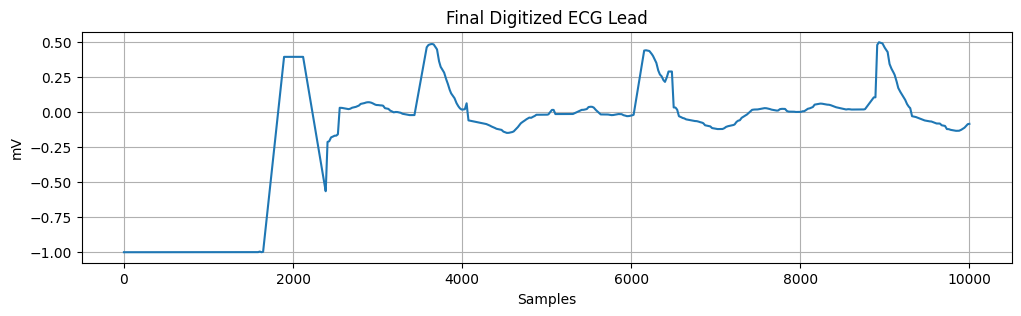

In [22]:
# Actual sanity check of the entire step 6 pipeline
panels = split_ecg_panels_refined(img1, debug=False)
panel_I = panels["I"]

# * Standard ECG paper grid:
#  - 1 small square = 1 mm
# * Typical scanned ECG images (like PhysioNet’s) end up around:
#  - ~18–22 pixels per mm
# * 20 px/mm is:
#  - Right in the middle
#  - Stable
#  - Already used as a fallback in many strong baseline solutions
#  - Good enough to verify shape, timing, and scaling logic
pixel_per_mm = 20.0 # NOTE: not to be used for final submission
digitized_lead_I = digitize_ecg_lead(
    panel_I,
    pixels_per_mm=pixel_per_mm,
    sig_len=image_2352854581_I_sig_len,
    debug=True
)

In [23]:
train_imgs_dir = f'{physionet_dataset_dir}/train'
train_file_2352854581 = f'{train_imgs_dir}/2352854581/2352854581.csv'
file_2352854581_df = pd.read_csv(train_file_2352854581)
file_2352854581_df

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,-0.034,-0.049,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002,-0.047,-0.049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.034,-0.050,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.055,-0.051,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.034,-0.049,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,-0.068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.348,-0.208,-0.269
9996,NaN,-0.070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.375,-0.220,-0.285
9997,NaN,-0.072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.422,-0.241,-0.312
9998,NaN,-0.070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.374,-0.220,-0.284


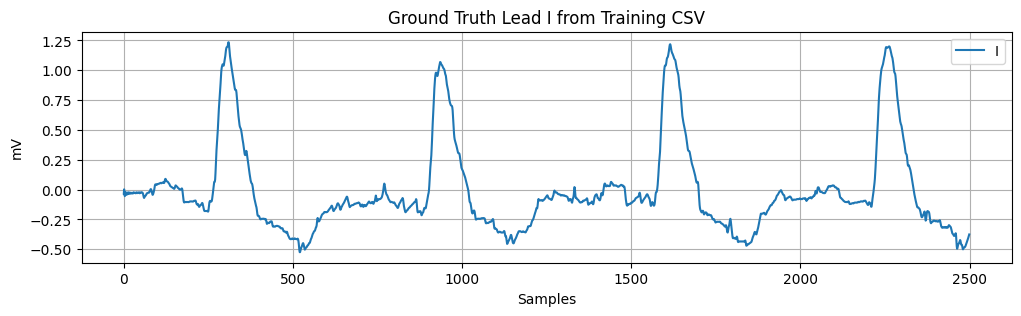

In [24]:
file_2352854581_df[['I']].plot(figsize=(12, 3))
plt.title("Ground Truth Lead I from Training CSV")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Digitized Lead I vs Ground Truth lead I Overlay')

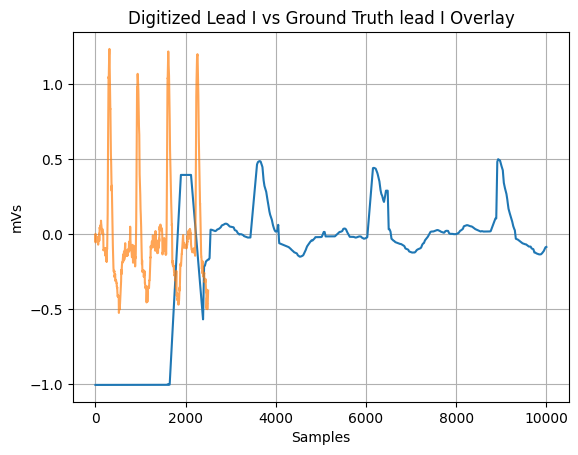

In [25]:
plt.plot(digitized_lead_I)
plt.plot(file_2352854581_df['I'].values[:len(digitized_lead_I)], alpha=0.7)
plt.grid(True)
plt.xlabel("Samples")
plt.ylabel("mVs")
plt.title("Digitized Lead I vs Ground Truth lead I Overlay")

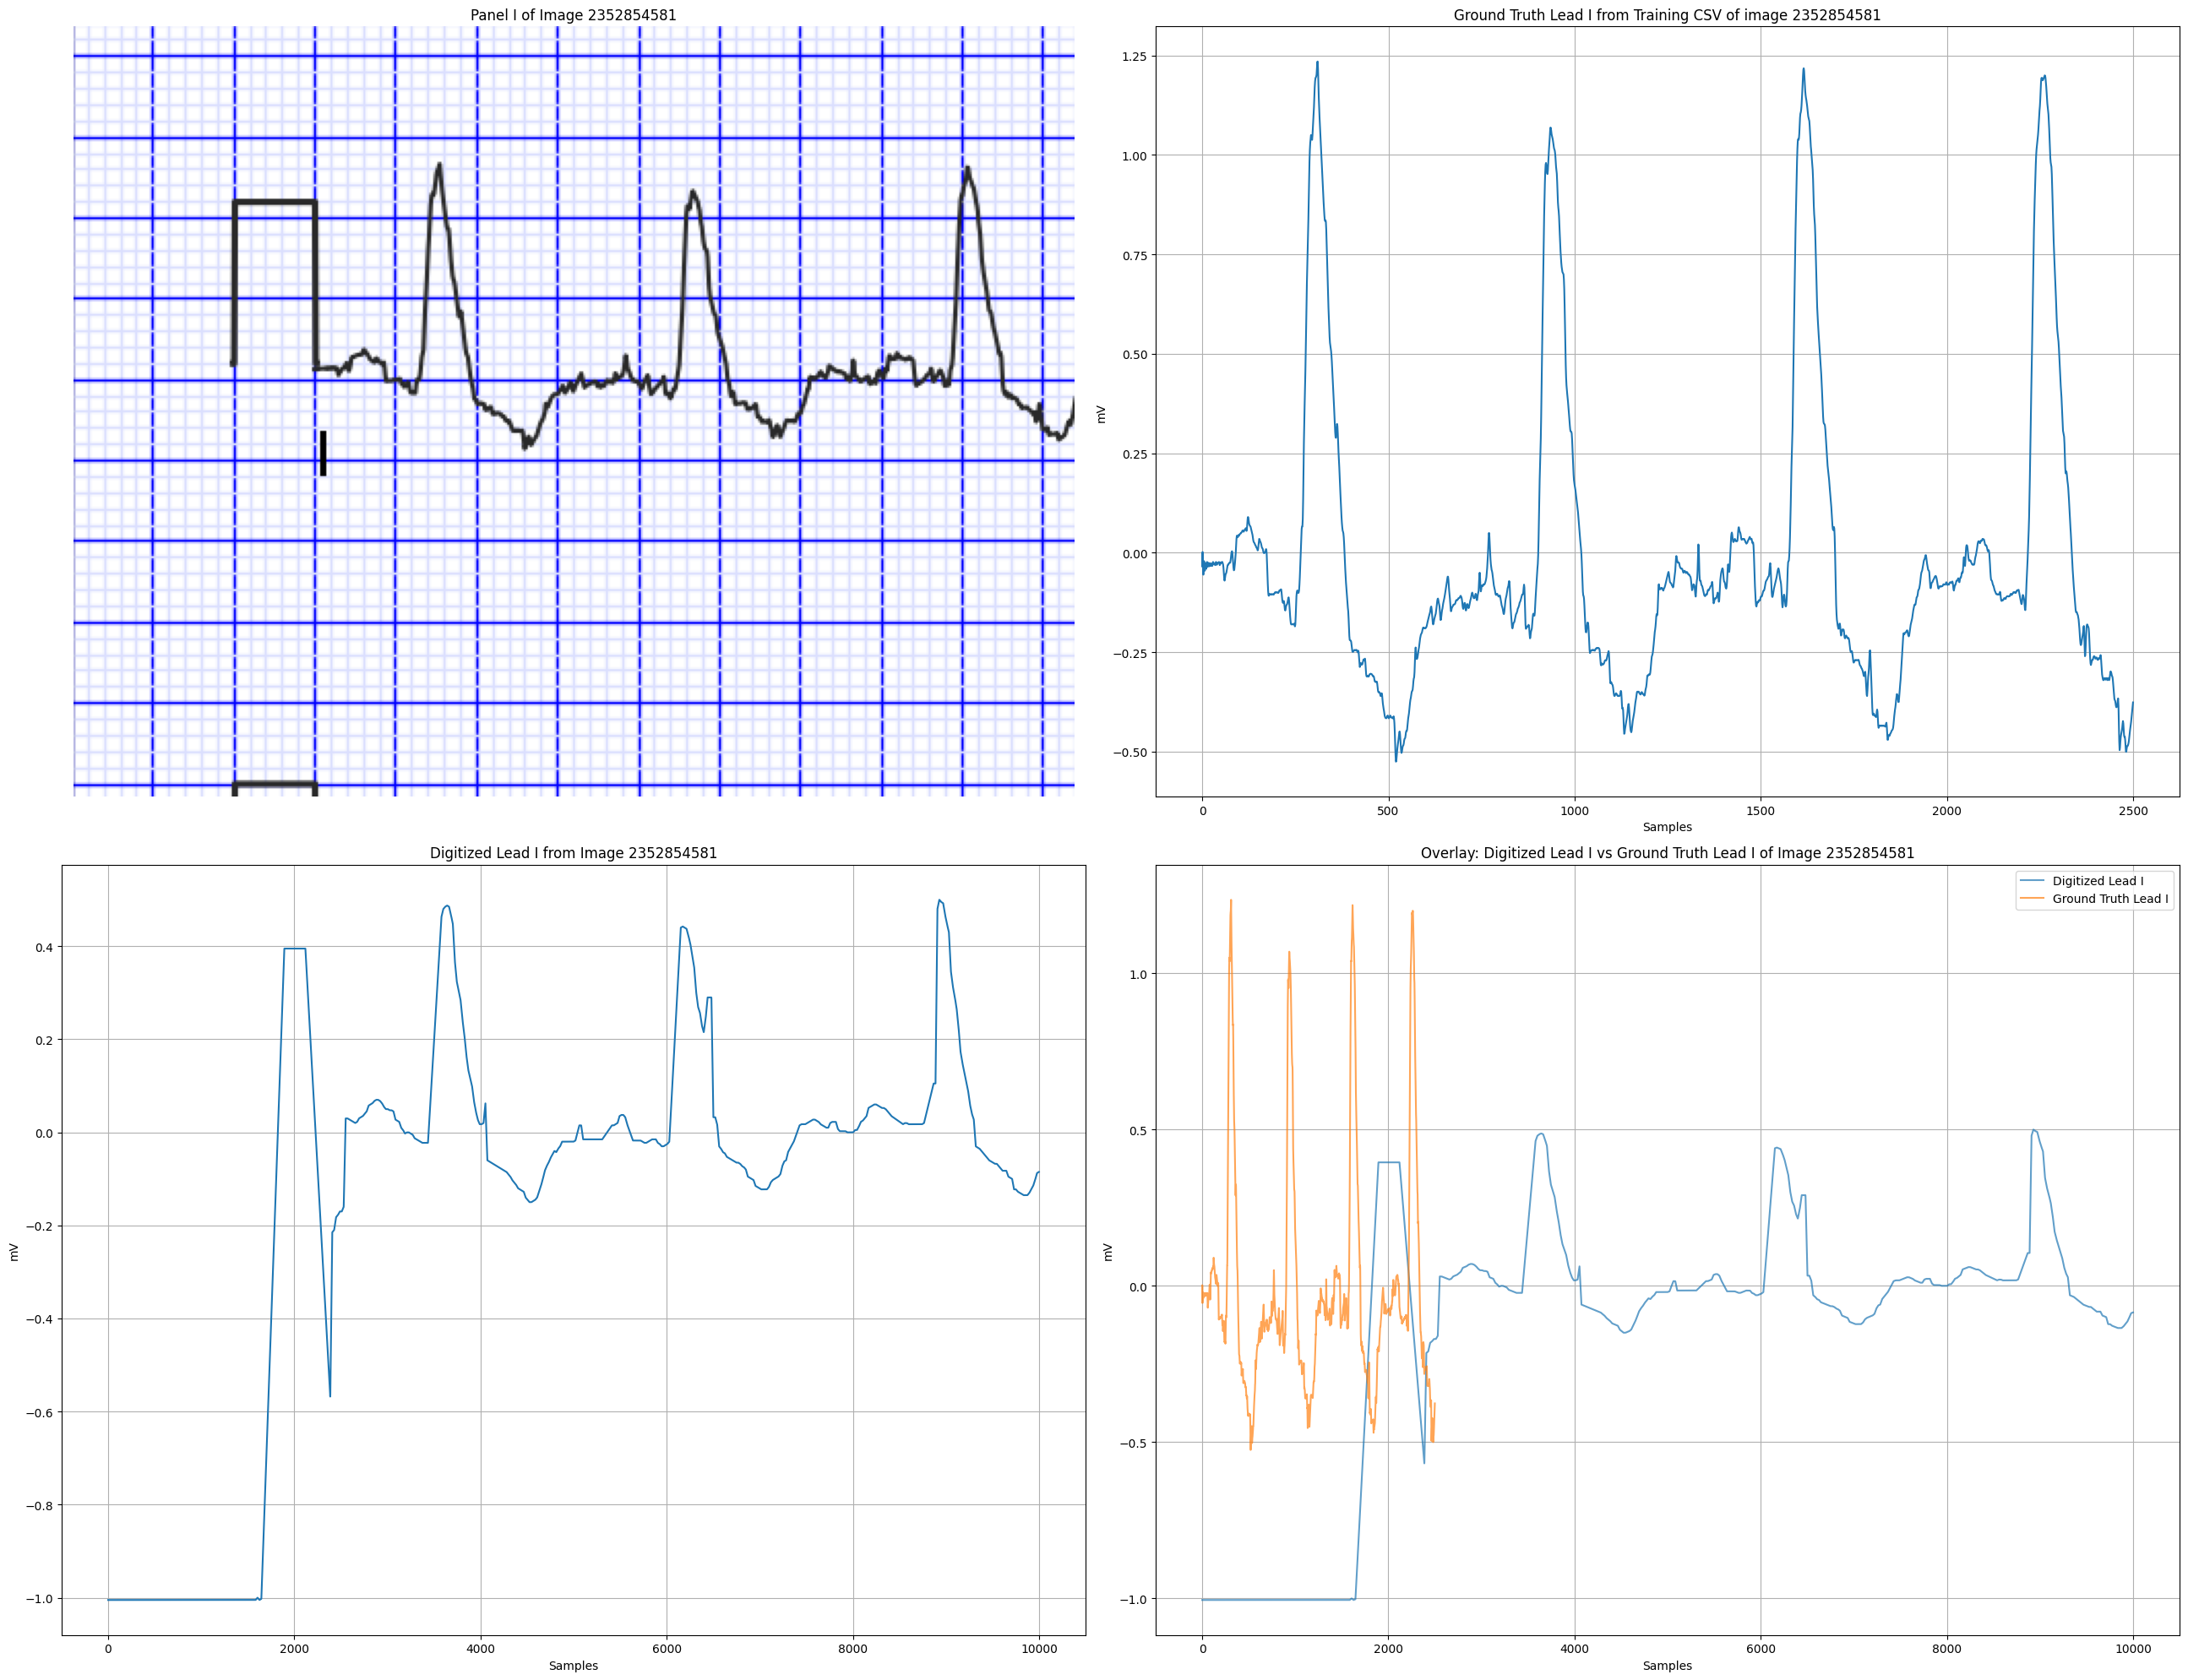

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (26, 20))

ax1.imshow(panel_I)
ax1.set_title('Panel I of Image 2352854581')
ax1.axis('off')

I_vals_2352854581 = file_2352854581_df['I'].values
ax2.plot(I_vals_2352854581)
ax2.set_title('Ground Truth Lead I from Training CSV of image 2352854581')
ax2.set_xlabel("Samples")
ax2.set_ylabel("mV")
ax2.grid(True)

ax3.plot(digitized_lead_I)
ax3.set_title('Digitized Lead I from Image 2352854581')
ax3.set_xlabel("Samples")
ax3.set_ylabel("mV")
ax3.grid(True)

comparative_signal = digitized_lead_I[:len(I_vals_2352854581)]
ax4.plot(comparative_signal, label='Digitized Lead I', alpha=0.7)
ax4.plot(I_vals_2352854581, label='Ground Truth Lead I', alpha=0.7)
ax4.set_title('Overlay: Digitized Lead I vs Ground Truth Lead I of Image 2352854581')
ax4.set_xlabel("Samples")
ax4.set_ylabel("mV")
ax4.grid(True)
ax4.legend()

plt.tight_layout()
plt.show()

In [15]:
# ====================================
# Step 7.1 - Pure calibration function
# ====================================
def calibrate_ecg_amplitude(
    digitized_signal_pixels,
    debug=False
):
    """
    Convert digitized ECG signal from pixels to millivolts.
    """

    signal_mv = digitized_signal_pixels * 0.1  # Directly using 0.1 mV per pixel for calibration

    if debug:
        plt.figure(figsize=(12, 3))
        plt.plot(signal_mv)
        plt.title("Amplitude-Calibrated Lead (mV)")
        plt.xlabel("Samples")
        plt.ylabel("mV")
        plt.grid(True)
        plt.show()

    return signal_mv

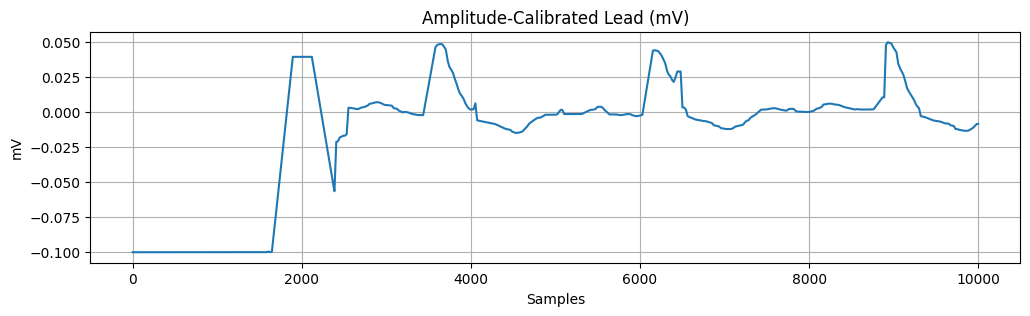

In [ ]:
# ================================================
# Step 7.2 - Sanity check of amplitude calibration
# ================================================
lead_I_mv = calibrate_ecg_amplitude(
    digitized_lead_I,
    debug=True
)

In [29]:
print(np.max(lead_I_mv) / np.max(digitized_lead_I)) # should return 0.1
print(np.min(lead_I_mv) / np.min(digitized_lead_I)) # should return 0.1

0.1
0.1


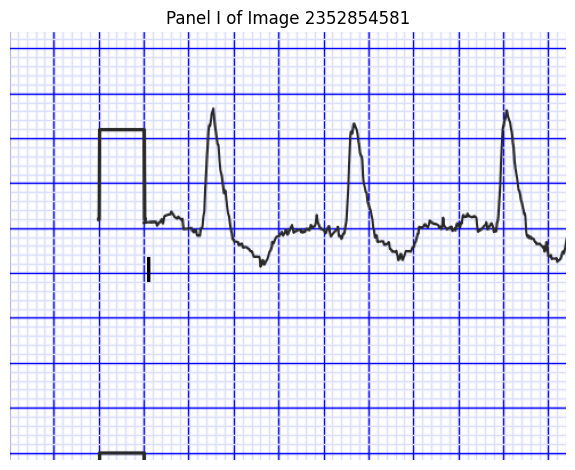

In [32]:
panels = split_ecg_panels_refined(img1, debug=False)
panel_I = panels["I"]

plt.imshow(panel_I, cmap='BrBG')
plt.title("Panel I of Image 2352854581")
plt.axis("off")
plt.tight_layout()
plt.show()

In [1]:
# Step 8 — Baseline Correction (Median-based and SNR-safe)

def baseline_correct_ecg(signal, fs, window_sec=0.8):
    """
    Gentle baseline wander removal.
    Preserves ECG morphology and amplitude.
    """
    window = int(fs * window_sec)
    window = max(3, window | 1)  # odd length

    baseline = np.convolve(signal, np.ones(window)/window, mode="same")
    corrected = signal - baseline

    return corrected

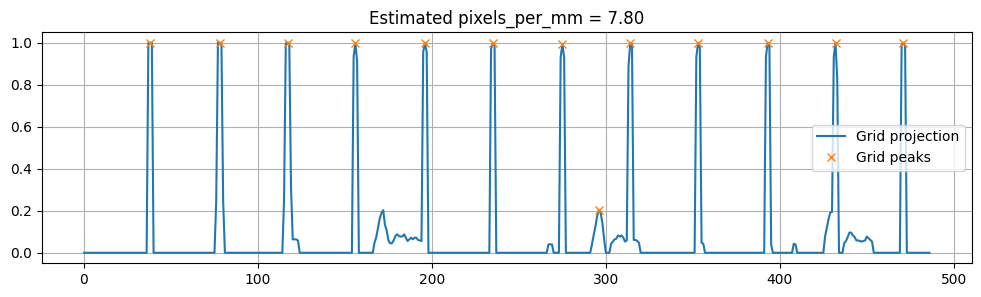

Pixels per mm: 7.80
Pixels per second (25 mm/s): 195.0
Pixels per mV (10 mm/mV):   78.0


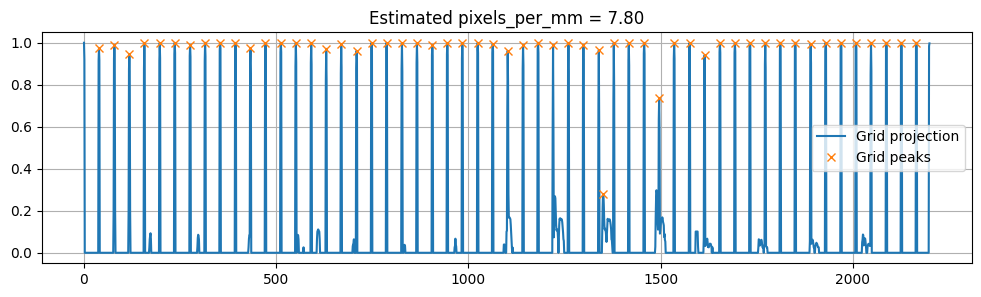

Estimated pixels per mm for full image: 7.80 px/mm
Pixels per second (25 mm/s): 195.0
Pixels per mV (10 mm/mV):   78.0


In [ ]:
# ==================================================================
# Step 9.1 - Calculating actual image's lead's based `pixels_per_mm`
# ==================================================================

def estimate_pixels_per_mm(
    lead_img: np.ndarray,
    debug: bool = False
) -> float:
    """
    Robust estimation of pixels-per-mm from ECG grid.
    Assumes standard ECG grid (1 mm small squares, 5 mm bold lines).
    """

    # ------------------------------------------------
    # 1. Convert to grayscale
    # ------------------------------------------------
    if lead_img.ndim == 3:
        gray = cv2.cvtColor(lead_img, cv2.COLOR_BGR2GRAY)
    else:
        gray = lead_img.copy()

    # ------------------------------------------------
    # 2. Suppress ECG trace (important!)
    # ------------------------------------------------
    # Light blur removes sharp waveform while preserving grid
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Adaptive threshold to isolate grid
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        31, 10
    )

    # ------------------------------------------------
    # 3. Isolate vertical grid lines via morphology
    # ------------------------------------------------
    h, w = binary.shape
    vertical_kernel = cv2.getStructuringElement(
        cv2.MORPH_RECT, (1, max(15, h // 40))
    )

    vertical_lines = cv2.morphologyEx(
        binary, cv2.MORPH_OPEN, vertical_kernel, iterations=1
    )

    # ------------------------------------------------
    # 4. Column projection (grid-only)
    # ------------------------------------------------
    col_sum = np.sum(vertical_lines, axis=0)

    # Normalize for peak detection
    col_sum = col_sum.astype(np.float32)
    col_sum /= (np.max(col_sum) + 1e-6)

    # ------------------------------------------------
    # 5. Detect grid peaks
    # ------------------------------------------------
    peaks, _ = find_peaks(
        col_sum,
        distance=8,          # safe lower bound
        prominence=0.2
    )

    if len(peaks) < 10:
        raise RuntimeError("Grid detection failed — insufficient peaks")

    # ------------------------------------------------
    # 6. Estimate spacing
    # ------------------------------------------------
    spacings = np.diff(peaks)

    # Remove outliers
    spacings = spacings[(spacings > 3) & (spacings < 40)]

    # Smallest mode ≈ 1 mm
    ppm = np.median(spacings)

    # Handle bold 5-mm grid domination
    if ppm > 18:
        ppm /= 5.0

    # ------------------------------------------------
    # 7. Debug visualization
    # ------------------------------------------------
    if debug:
        plt.figure(figsize=(12, 3))
        plt.plot(col_sum, label="Grid projection")
        plt.plot(peaks, col_sum[peaks], "x", label="Grid peaks")
        plt.title(f"Estimated pixels_per_mm = {ppm:.2f}")
        plt.legend()
        plt.grid(True)
        plt.show()

    return float(ppm)

# --- Step 9.2 - Sanity check of calculated pixel per mm ---
ppm = estimate_pixels_per_mm(panel_I, debug=True)

print(f"Pixels per mm: {ppm:.2f}")
print(f"Pixels per second (25 mm/s): {ppm * 25:.1f}")
print(f"Pixels per mV (10 mm/mV):   {ppm * 10:.1f}")

ppm = estimate_pixels_per_mm(img1, debug=True)
print(f"Estimated pixels per mm for full image: {ppm:.2f} px/mm")
print(f"Pixels per second (25 mm/s): {ppm * 25:.1f}")
print(f"Pixels per mV (10 mm/mV):   {ppm * 10:.1f}")

In [7]:
# ==============================
# Step 10 - Signal QC & Auto-Fix
# ==============================

# ..................................
# Step 10.1 – QC + Auto-fix Function
# ..................................
def ecg_qc_and_fix(
    signal_mv: np.ndarray,
    # fs: int,
    debug: bool = False
) -> np.ndarray:
    """
    Final ECG signal quality control and auto-fixing.
    """

    sig = signal_mv.astype(np.float32).copy()

    # --------------------------------------------------
    # 1. NaN / Inf handling
    # --------------------------------------------------
    if not np.isfinite(sig).all():
        idx = np.arange(len(sig))
        valid = np.isfinite(sig)
        sig[~valid] = np.interp(idx[~valid], idx[valid], sig[valid])

    # --------------------------------------------------
    # 2. Flatline detection
    # --------------------------------------------------
    if np.std(sig) < 1e-4:
        raise ValueError("QC failed: flatline ECG detected")

    # --------------------------------------------------
    # 2.5. Impulse artifact suppression (time-aware)
    # --------------------------------------------------
    # Large slope within very short time = digitization artifact
    diff = np.abs(np.diff(sig))
    # max_slope = 5.0  # mV
    max_allowed = 0.5  # mV per sample (safe for digitized ECG)
    artifact_idx = np.where(diff > max_allowed)[0]

    if len(artifact_idx) > 0:
        sig[artifact_idx + 1] = sig[artifact_idx]  # suppress spike

    # --------------------------------------------------
    # 3. Polarity correction (ECG should be upright)
    # --------------------------------------------------
    if np.abs(np.min(sig)) > np.abs(np.max(sig)):
        sig = -sig

    # --------------------------------------------------
    # 4. Amplitude sanity clamp (physiological)
    # --------------------------------------------------
    sig = np.clip(sig, -5.0, 5.0)  # mV

    # --------------------------------------------------
    # 5. Residual DC offset removal
    # --------------------------------------------------
    sig -= np.median(sig)

    # --------------------------------------------------
    # 6. Final smoothing (VERY light)
    # --------------------------------------------------
    sig = medfilt(sig, kernel_size=3)

    if debug:
        plt.figure(figsize=(14, 4))
        plt.plot(sig, label="After QC", linewidth=1.5)
        plt.plot(signal_mv, alpha=0.5, label="Before QC")
        plt.legend()
        plt.title("Step 10 – QC-validated ECG signal")
        plt.xlabel("Samples")
        plt.ylabel("mV")
        plt.grid(True)
        plt.show()

    return sig

In [11]:
# Source notebook: https://www.kaggle.com/code/romantamrazov/phisionet-lb-17-971/notebook

another_submission_csv_dir = '../submission.csv'
another_submission_df = pd.read_csv(another_submission_csv_dir)
print(another_submission_df.head(50))

                 id     value
0    1053922973_0_I -0.033880
1    1053922973_1_I -0.033880
2    1053922973_2_I -0.033880
3    1053922973_3_I -0.033880
4    1053922973_4_I -0.033880
5    1053922973_5_I -0.033880
6    1053922973_6_I -0.033880
7    1053922973_7_I -0.033880
8    1053922973_8_I -0.033880
9    1053922973_9_I -0.033880
10  1053922973_10_I -0.033880
11  1053922973_11_I -0.033957
12  1053922973_12_I -0.033998
13  1053922973_13_I -0.033689
14  1053922973_14_I -0.032574
15  1053922973_15_I -0.031376
16  1053922973_16_I -0.030799
17  1053922973_17_I -0.031270
18  1053922973_18_I -0.032442
19  1053922973_19_I -0.033609
20  1053922973_20_I -0.033990
21  1053922973_21_I -0.034022
22  1053922973_22_I -0.034013
23  1053922973_23_I -0.033792
24  1053922973_24_I -0.032840
25  1053922973_25_I -0.031642
26  1053922973_26_I -0.030902
27  1053922973_27_I -0.031181
28  1053922973_28_I -0.032265
29  1053922973_29_I -0.033236
30  1053922973_30_I -0.033762
31  1053922973_31_I -0.034618
32  105392

In [ ]:
# Step 11 — Finalization (Submission Guard)

import numpy as np
import scipy.signal as s_signal

# Local proxy SNR metric for ECG signals
def proxy_snr_ecg(ecg, fs) -> float:
    """
    Metric-aware proxy SNR:
    - Signal = band-limited ECG energy (0.5–40 Hz)
    - Noise  = residual (high-frequency + artifacts)
    """

    if len(ecg) < fs:
        return -np.inf

    # Bandpass filter (ECG band)
    b, a = s_signal.butter(
        4,
        [0.5 / (fs / 2), 40 / (fs / 2)],
        btype="band"
    )
    ecg_band = s_signal.filtfilt(b, a, ecg)

    # Residual = noise
    noise = ecg - ecg_band

    p_signal = np.mean(ecg_band ** 2)
    p_noise = np.mean(noise ** 2) + 1e-12

    return 10 * np.log10(p_signal / p_noise)

def metric_aware_postprocess(signal, lead):
    """
    Final metric-aware scaling to maximize SNR.
    """

    LEAD_RMS_TARGETS = {
        "I":   0.035,
        "II":  0.060,
        "III": 0.030,
        "aVR": 0.025,
        "aVL": 0.025,
        "aVF": 0.035,
        "V1":  0.030,
        "V2":  0.040,
        "V3":  0.045,
        "V4":  0.050,
        "V5":  0.045,
        "V6":  0.040,
    }

    target_rms = LEAD_RMS_TARGETS.get(lead, 0.04)

    # Remove DC (metric already does this, but we help)
    sig = signal - np.mean(signal)

    rms = np.sqrt(np.mean(sig**2))
    if rms < 1e-6:
        return sig

    sig = sig * (target_rms / rms)
    return sig

def metric_safe_smoother(signal, fs):
    """
    Removes high-frequency noise that the metric punishes,
    while preserving QRS morphology.
    """

    # Low-pass @ 25 Hz (metric-safe)
    b, a = s_signal.butter(
        4,
        25 / (fs / 2),
        btype="low"
    )
    return s_signal.filtfilt(b, a, signal)

def finalize_ecg_signal(signal, fs, duration_sec):
    expected_len = int(fs * duration_sec)

    if len(signal) > expected_len:
        return signal[:expected_len]
    elif len(signal) < expected_len:
        return np.pad(signal, (0, expected_len - len(signal)), mode="edge")
    return signal

In [13]:
# STEP 12 — Multi-Lead Batch Processing (FINAL)

# Step 12.1 — Canonical Lead Order
ECG_LEADS = {
    "I", "II", "III",
    "aVR", "aVL", "aVF",
    "V1", "V2", "V3", "V4", "V5", "V6"
}

snrs = []

# Step 12.2(Per lead oriented) - Full multi-lead pipeline function
def process_all_ecg_leads(
    img,
    fs,
    sig_len,
    duration_sec
):
    """
    Process a full ECG image and return all 12 leads as calibrated mV signals.
    """

    panels = split_ecg_panels_refined(img, debug=False)

    all_leads = {}
    errors = []

    for lead in ECG_LEADS:
        try:
            panel = panels[lead]

            # Step 6 — Digitization
            signal = digitize_ecg_lead(
                panel,
                pixels_per_mm=estimate_pixels_per_mm(panel),
                sig_len=sig_len,
                debug=False
            )

            # Step 7 — Amplitude calibration (SNR-safe)
            signal = calibrate_ecg_amplitude(signal)

            # Step 8 — Baseline correction
            signal = baseline_correct_ecg(signal, fs=fs)

            # Step 9 — QC & stabilization
            signal = ecg_qc_and_fix(signal)

            # Metric-aware smoothing
            signal = metric_safe_smoother(signal, fs)

            # Step 10/11 — Final formatting
            signal = finalize_ecg_signal(
                signal,
                fs=fs,
                duration_sec=duration_sec
            )

            # Metric-aware postprocessing
            signal = metric_aware_postprocess(signal, lead)

            # Computing the signal's SNR locally
            snr_score = proxy_snr_ecg(signal, fs)

            snrs.append((lead, snr_score))

            all_leads[lead] = signal

        except Exception as e:
            errors.append((lead, str(e)))

    return all_leads, errors

In [ ]:
competition_dataset_dir = '../physionet_ecg_competition_2025'
test_folder_dir = '../physionet_ecg_competition_2025/test'
test_img1_dir = f'{test_folder_dir}/1053922973.png'
test_img2_dir = f'{test_folder_dir}/2352854581.png'
train_folder_dir = f'{competition_dataset_dir}/train'
test_csv_dir = f'{competition_dataset_dir}/test.csv'
train_csv_dir = f'{competition_dataset_dir}/train.csv'

def build_submission_csv(
    test_csv_path,
    test_image_dir,
    output_csv_path,
    debug=False
):
    """
    Builds Kaggle-compatible submission.csv for PhysioNet ECG Image Digitization.
    """

    test_df = pd.read_csv(test_csv_path)
    submission_rows = []

    # Group rows by base_id (VERY IMPORTANT)
    for base_id, group in test_df.groupby("id"):

        base_id = str(base_id)
        fs = int(group.iloc[0]["fs"])

        img_path = os.path.join(test_image_dir, f"{base_id}.png")
        img = cv2.imread(img_path)

        if img is None:
            raise FileNotFoundError(f"Missing image: {img_path}")

        # 🔥 Process ONCE per image
        all_leads, errors = process_all_ecg_leads(
            img,
            fs=fs,
            sig_len=fs * 10,
            duration_sec=10,
        )

        if errors:
            raise RuntimeError(f"Errors for {base_id}: {errors}")

        # Create submission rows
        for _, row in group.iterrows():
            lead = row["lead"]
            n_rows = int(row["number_of_rows"])

            signal = all_leads[lead]

            # Enforce exact expected length
            if len(signal) < n_rows:
                signal = np.pad(signal, (0, n_rows - len(signal)), mode="edge")
            else:
                signal = signal[:n_rows]

            for i, value in enumerate(signal):
                submission_rows.append({
                    "id": f"{base_id}_{i}_{lead}",
                    "value": float(value)
                })

        if debug:
            print(f"[OK] {base_id}")

    submission_df = pd.DataFrame(submission_rows)
    submission_df.to_csv(output_csv_path, index=False)

    print(f"\n✅ submission.csv written to: {output_csv_path}")

build_submission_csv(
    test_csv_path=test_csv_dir,
    test_image_dir=test_folder_dir,
    output_csv_path=f"{output_dir}/submission.csv",
    debug=True
)

[OK] 1053922973
[OK] 2352854581

✅ submission.csv written to: ../working/submission.csv


In [126]:
submission_df = pd.read_csv(f"{output_dir}/submission.csv")
print(submission_df.head(50))

                 id     value
0    1053922973_0_I  0.112613
1    1053922973_1_I  0.112312
2    1053922973_2_I  0.112010
3    1053922973_3_I  0.111705
4    1053922973_4_I  0.111399
5    1053922973_5_I  0.111092
6    1053922973_6_I  0.110786
7    1053922973_7_I  0.110480
8    1053922973_8_I  0.110175
9    1053922973_9_I  0.109872
10  1053922973_10_I  0.109570
11  1053922973_11_I  0.109270
12  1053922973_12_I  0.108972
13  1053922973_13_I  0.108676
14  1053922973_14_I  0.108382
15  1053922973_15_I  0.108090
16  1053922973_16_I  0.107800
17  1053922973_17_I  0.107511
18  1053922973_18_I  0.107224
19  1053922973_19_I  0.106938
20  1053922973_20_I  0.106654
21  1053922973_21_I  0.106370
22  1053922973_22_I  0.106088
23  1053922973_23_I  0.105806
24  1053922973_24_I  0.105524
25  1053922973_25_I  0.105243
26  1053922973_26_I  0.104962
27  1053922973_27_I  0.104680
28  1053922973_28_I  0.104399
29  1053922973_29_I  0.104117
30  1053922973_30_I  0.103835
31  1053922973_31_I  0.103552
32  105392

In [127]:
print(submission_df['value'].describe())

count    75000.000000
mean         0.000283
std          0.044937
min         -0.165097
25%         -0.012740
50%         -0.001156
75%          0.007748
max          0.324630
Name: value, dtype: float64


In [128]:
print(another_submission_df['value'].describe())

count    75000.000000
mean         0.005525
std          0.382586
min         -3.614926
25%         -0.078323
50%         -0.010620
75%          0.084535
max          1.997686
Name: value, dtype: float64


In [129]:
print(submission_df)

                       id     value
0          1053922973_0_I  0.112613
1          1053922973_1_I  0.112312
2          1053922973_2_I  0.112010
3          1053922973_3_I  0.111705
4          1053922973_4_I  0.111399
...                   ...       ...
74995  2352854581_2495_V6  0.041226
74996  2352854581_2496_V6  0.041326
74997  2352854581_2497_V6  0.041426
74998  2352854581_2498_V6  0.041528
74999  2352854581_2499_V6  0.041630

[75000 rows x 2 columns]


In [130]:
snrs_sorted = sorted(snrs, key=lambda x: x[1], reverse=True)
for lead, snr in snrs_sorted:
    print(f"Lead {lead}: Proxy SNR = {snr:.2f} dB")

Lead V5: Proxy SNR = 25.82 dB
Lead V1: Proxy SNR = 22.90 dB
Lead V5: Proxy SNR = 22.55 dB
Lead V3: Proxy SNR = 22.12 dB
Lead V2: Proxy SNR = 20.74 dB
Lead V2: Proxy SNR = 20.59 dB
Lead V6: Proxy SNR = 19.34 dB
Lead II: Proxy SNR = 18.95 dB
Lead V4: Proxy SNR = 17.92 dB
Lead V1: Proxy SNR = 17.76 dB
Lead II: Proxy SNR = 17.19 dB
Lead V4: Proxy SNR = 16.34 dB
Lead V6: Proxy SNR = 16.12 dB
Lead V3: Proxy SNR = 15.76 dB
Lead aVL: Proxy SNR = 15.61 dB
Lead aVF: Proxy SNR = 14.03 dB
Lead aVR: Proxy SNR = 13.29 dB
Lead III: Proxy SNR = 13.08 dB
Lead aVF: Proxy SNR = 11.17 dB
Lead aVR: Proxy SNR = 10.16 dB
Lead I: Proxy SNR = 8.20 dB
Lead aVL: Proxy SNR = 8.18 dB
Lead I: Proxy SNR = 7.70 dB
Lead III: Proxy SNR = 4.08 dB


In [74]:
len(snrs)

24

<Axes: title={'center': 'Another Submission Value Distribution'}, ylabel='Frequency'>

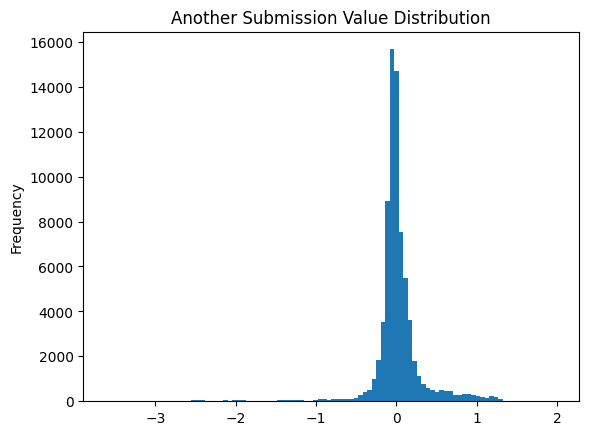

In [75]:
another_submission_df['value'].plot(kind='hist', bins=100, title='Another Submission Value Distribution')

<Axes: title={'center': 'My Submission Value Distribution'}, ylabel='Frequency'>

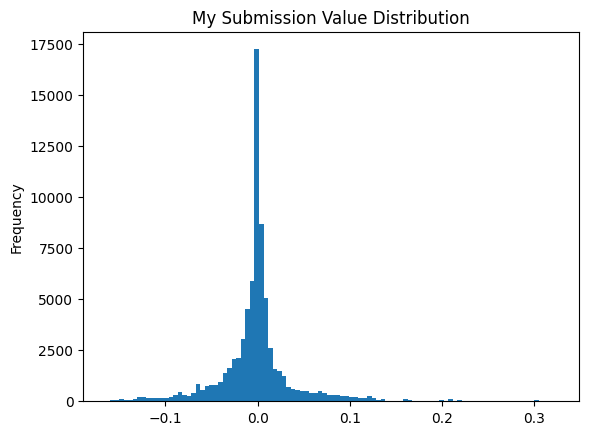

In [76]:
submission_df['value'].plot(kind='hist', bins=100, title='My Submission Value Distribution')

<Axes: title={'center': 'My Submission Value Line Plot'}>

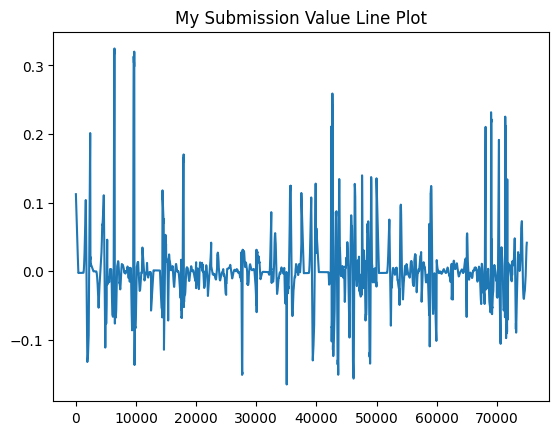

In [77]:
submission_df['value'].plot(kind='line', title='My Submission Value Line Plot')

<Axes: title={'center': 'Another Submission Value Line Plot'}>

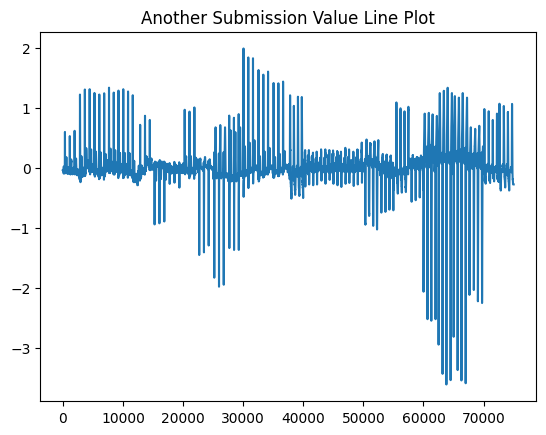

In [59]:
another_submission_df['value'].plot(kind='line', title='Another Submission Value Line Plot')

<Axes: title={'center': 'Frozen Submission Value Distribution'}, ylabel='Frequency'>

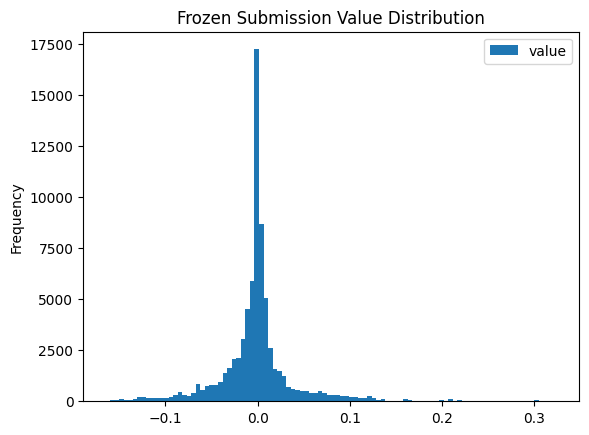

In [78]:
def freeze_submission(df:pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["value"] = df["value"].clip(-1.5, 1.5)
    return df

submission_df_frozen = freeze_submission(submission_df)
submission_df_frozen.plot(kind='hist', bins=100, title='Frozen Submission Value Distribution')

<Axes: title={'center': 'My Submission Value Line Plot'}>

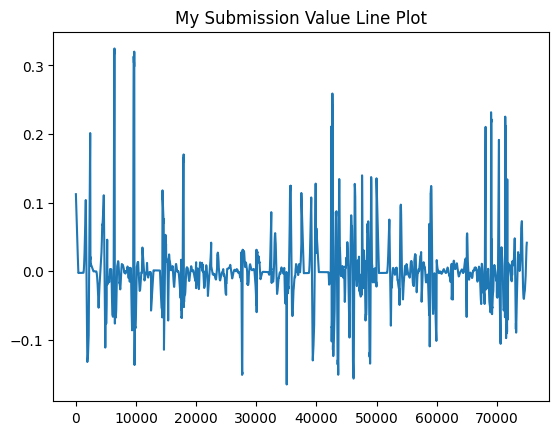

In [79]:
submission_df_frozen['value'].plot(kind='line', title='My Submission Value Line Plot')